# Efficient RPE-ViT Experiments

Interactive notebook for training and testing Vision Transformers.

## 1. Setup and Imports

In [1]:
import os, sys, time, json
from pathlib import Path
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Project imports
from models import create_model, list_available_models, get_model_info
from data.datasets import get_dataloaders, visualize_batch, get_sample_batch
from experiments.utils.training import (
    train_epoch,
    evaluate,
    benchmark_inference,
    create_optimizer,
    create_lr_scheduler
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"PyTorch: {torch.__version__}")

torch.manual_seed(42)
np.random.seed(42)

Device: cpu
PyTorch: 2.2.2


## 2. Configure Experiment

In [2]:
# Configuration
DATASET = 'mnist'  # 'mnist' or 'cifar10'
MODEL_NAME = 'performer_relu'
BATCH_SIZE = 256
EPOCHS = 4
LEARNING_RATE = 1e-3

# Load config
if DATASET == 'mnist':
    from configs.mnist_config import MNIST_CONFIG
    config = MNIST_CONFIG.copy()
else:
    from configs.cifar10_config import CIFAR10_CONFIG
    config = CIFAR10_CONFIG.copy()

config['batch_size'] = BATCH_SIZE
config['learning_rate'] = LEARNING_RATE

print(f"Dataset: {DATASET.upper()}")
print(f"Model: {MODEL_NAME}")
print(f"Batch size: {BATCH_SIZE}, Epochs: {EPOCHS}")

Dataset: MNIST
Model: performer_relu
Batch size: 256, Epochs: 4


## 3. Load Data

In [3]:
train_loader, test_loader, data_config = get_dataloaders(
    dataset=DATASET,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=(device.type == 'cuda'),
    augmentation=False,
    config=config
)

print(f"Train samples: {len(train_loader.dataset):,}")
print(f"Test samples: {len(test_loader.dataset):,}")
print(f"Batches/epoch: {len(train_loader):,}")

Loaded MNIST: 60000 train, 10000 test samples
Batch size: 256
Train batches: 234
Test batches: 40
Train samples: 60,000
Test samples: 10,000
Batches/epoch: 234


## 4. Create Model

In [4]:
model_info = get_model_info(MODEL_NAME)
print(f"Attention: {model_info['attention_type']} ({model_info['attention_complexity']})")
print(f"RPE: {model_info['rpe_type'] or 'None'}")

model = create_model(MODEL_NAME, config).to(device)
params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {params:,}")

Attention: relu (O(N))
RPE: None
Parameters: 27,914


## 5. Training Setup

In [5]:
optimizer = create_optimizer(
    model=model,
    optimizer_type='adamw',
    learning_rate=LEARNING_RATE,
    weight_decay=0.1
)

scheduler = create_lr_scheduler(
    optimizer=optimizer,
    scheduler_type='cosine',
    num_epochs=EPOCHS,
    warmup_epochs=1
)

criterion = nn.CrossEntropyLoss()
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Scheduler: {scheduler.__class__.__name__ if scheduler else 'None'}")

Optimizer: AdamW
Scheduler: LambdaLR


## 6. Training Loop

In [6]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc = 0

for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_metrics = train_epoch(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epoch=epoch,
        log_interval=50
    )
    
    # Evaluate
    val_metrics = evaluate(
        model=model,
        test_loader=test_loader,
        criterion=criterion,
        device=device
    )
    
    # Update LR
    if scheduler:
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
    else:
        current_lr = LEARNING_RATE
    
    # Store history
    history['train_loss'].append(train_metrics['loss'])
    history['train_acc'].append(train_metrics['accuracy'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['lr'].append(current_lr)
    
    # Print
    print(f"\nTrain Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['accuracy']:.2f}%")
    print(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.2f}%")
    
    if val_metrics['accuracy'] > best_val_acc:
        best_val_acc = val_metrics['accuracy']
        print(f"🎯 New best: {best_val_acc:.2f}%")

print(f"\nBest Val Acc: {best_val_acc:.2f}%")


Epoch 1/4
[   0.0s] Train Epoch: 0 [0/234 (0%)]	Loss: 2.719221
[   0.0s] Train Epoch: 0 [5/234 (2%)]	Loss: 2.687021
[   0.0s] Train Epoch: 0 [10/234 (4%)]	Loss: 2.735094
[   0.0s] Train Epoch: 0 [15/234 (6%)]	Loss: 2.789732
[   0.0s] Train Epoch: 0 [19/234 (8%)]	Loss: 2.777384
[   0.0s] Train Epoch: 0 [24/234 (10%)]	Loss: 2.767314
[   0.0s] Train Epoch: 0 [29/234 (12%)]	Loss: 2.787619
[   0.0s] Train Epoch: 0 [33/234 (14%)]	Loss: 2.816339
[   0.0s] Train Epoch: 0 [38/234 (16%)]	Loss: 2.759972
[   0.0s] Train Epoch: 0 [43/234 (18%)]	Loss: 2.689211
[   0.0s] Train Epoch: 0 [47/234 (20%)]	Loss: 2.630793
[   0.0s] Train Epoch: 0 [52/234 (22%)]	Loss: 2.638673
[   0.0s] Train Epoch: 0 [57/234 (24%)]	Loss: 2.792779
[   0.0s] Train Epoch: 0 [61/234 (26%)]	Loss: 2.792315
[   0.0s] Train Epoch: 0 [66/234 (28%)]	Loss: 2.795801
[   0.0s] Train Epoch: 0 [71/234 (30%)]	Loss: 2.758273
[   0.0s] Train Epoch: 0 [75/234 (32%)]	Loss: 2.741072
[   0.0s] Train Epoch: 0 [80/234 (34%)]	Loss: 2.730781
[   0.

## 7. Visualize Results

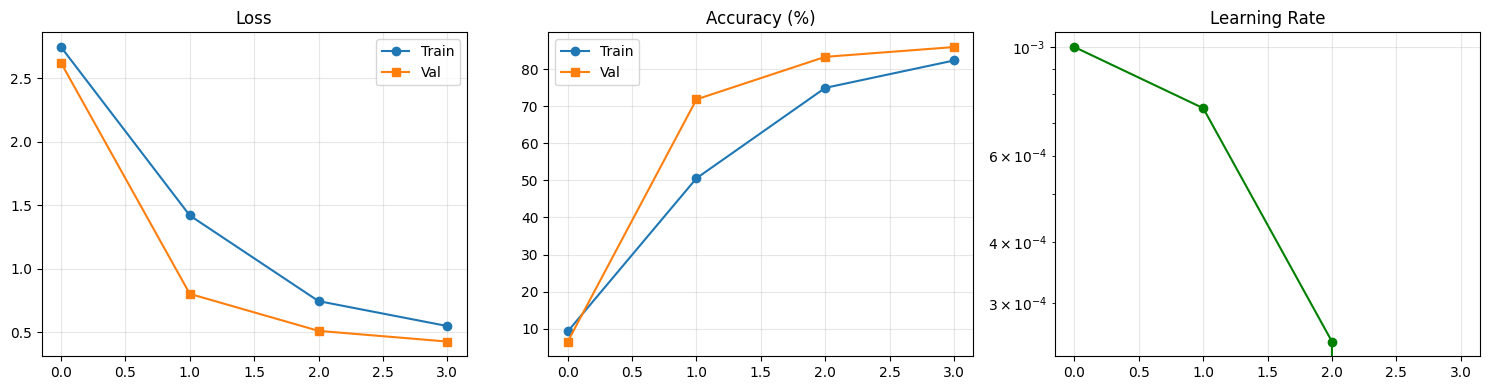

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'], 'o-', label='Train')
axes[0].plot(history['val_loss'], 's-', label='Val')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], 'o-', label='Train')
axes[1].plot(history['val_acc'], 's-', label='Val')
axes[1].set_title('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['lr'], 'o-', color='green')
axes[2].set_title('Learning Rate')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Benchmark Models

In [8]:
models_to_compare = ['baseline', 'performer_favor', 'performer_favor_most_general']
results = {}

for name in models_to_compare:
    print(f"\nBenchmarking {name}...")
    m = create_model(name, config).to(device).eval()

    # Use the actual benchmark_inference signature
    bench_results = benchmark_inference(
        model=m,
        test_loader=test_loader,  # Use the test_loader we created earlier
        device=device,
        num_warmup=5,
        num_benchmark=20  # Note: parameter is 'num_benchmark' not 'num_iterations'
    )

    info = get_model_info(name)
    results[name] = {
        'attention': info['attention_type'],
        'rpe': info['rpe_type'] or 'None',
        'params': sum(p.numel() for p in m.parameters()),
        'latency_ms': bench_results['avg_latency_ms'],
        'throughput': bench_results['throughput_imgs_per_s'],
        'memory_mb': bench_results['peak_memory_mb']
    }

    del m
    if device.type == 'cuda':
        torch.cuda.empty_cache()

# Display results
print(f"\n{'='*95}")
print(f"{'Model':<30} {'Attention':<15} {'RPE':<15} {'Params':>10} {'Latency(ms)':>12}")
print(f"{'='*95}")
for name, r in results.items():
    print(f"{name:<30} {r['attention']:<15} {r['rpe']:<15} {r['params']:>10,} {r['latency_ms']:>12.2f}")
print(f"{'='*95}")



Benchmarking baseline...
Running 5 warmup iterations...
Running 20 benchmark iterations...

Benchmarking performer_favor...
Running 5 warmup iterations...
Running 20 benchmark iterations...

Benchmarking performer_favor_most_general...
Running 5 warmup iterations...
Running 20 benchmark iterations...

Model                          Attention       RPE                 Params  Latency(ms)
baseline                       softmax         None                27,914        12.50
performer_favor                favor_plus      None                27,914        23.38
performer_favor_most_general   favor_plus      most_general        28,112       165.97
